In [34]:
#1: Imports and Setup
#%pip install pandas numpy seaborn matplotlib scikit-learn xgboost lightgbm river joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from river import compose, linear_model, preprocessing, metrics, ensemble
import joblib
import os
import warnings
warnings.filterwarnings("ignore")

In [35]:
#2: Load and Merge Data
data_dir = "./assets"
train_transaction_path = os.path.join(data_dir, "train_transaction.csv")
train_identity_path = os.path.join(data_dir, "train_identity.csv")

df_train = pd.read_csv(train_transaction_path)
df_identity = pd.read_csv(train_identity_path)
df = df_train.merge(df_identity, on="TransactionID", how="left")


In [55]:
# 3: Data Cleaning - Handling Missing Values

# Option 1: Fill missing values with -999
df_filled = df.copy()
df_filled.fillna(-999, inplace=True)

# Option 2: Drop rows with any missing values
print("Shape before dropna:", df.shape)
df_dropped = df.copy()
df_dropped.dropna(inplace=True)
print("Shape after dropna:", df_dropped.shape)


#Label Encoding for Categorical Columns
# cat_cols = df_dropped.select_dtypes(include=['object']).columns
# for col in cat_cols:
#     df_dropped[col] = LabelEncoder().fit_transform(df[col].astype(str))


Shape before dropna: (590540, 434)
Shape after dropna: (0, 434)


In [56]:
#4: Feature Selection and Splitting
features = [
    "TransactionAmt", "card1", "card2", "dist1", "C1", "C2", "D1", "V1", "V2"
]

X = df_filled[features]
y = df_filled["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

#Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [57]:

# Convert to NumPy arrays to ensure compatibility
X_train_np = np.array(X_train_scaled)
X_test_np = np.array(X_test_scaled)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier()
}

best_model = None
best_score = 0

for name, model in models.items():
    print(f"\nTraining and evaluating: {name}")
    try:
        model.fit(X_train_np, y_train_np)
        y_pred = model.predict(X_test_np)
        proba = model.predict_proba(X_test_np)[:, 1]
        auc = roc_auc_score(y_test_np, proba)

        print(f"{name} Report:")
        print(classification_report(y_test_np, y_pred, digits=4))
        print("ROC AUC:", auc)

        if auc > best_score:
            best_score = auc
            best_model = model

    except Exception as e:
        print(f"{name} failed with error: {e}")

# Save best model and assets if one succeeded
if best_model is not None:
    joblib.dump(best_model, "best_fraud_detection_model.pkl")
    joblib.dump(scaler, "scaler.pkl")
    joblib.dump(features, "features.pkl")
    print(f"\nBest Model: {best_model.__class__.__name__} with ROC AUC: {best_score}")
else:
    print("❌ No model was successfully trained.")


Training and evaluating: Logistic Regression
Logistic Regression Report:
              precision    recall  f1-score   support

           0     0.9824    0.5980    0.7434    113975
           1     0.0597    0.7043    0.1101      4133

    accuracy                         0.6017    118108
   macro avg     0.5211    0.6512    0.4268    118108
weighted avg     0.9501    0.6017    0.7213    118108

ROC AUC: 0.7039704756525289

Training and evaluating: Random Forest
Random Forest Report:
              precision    recall  f1-score   support

           0     0.9806    0.9958    0.9881    113975
           1     0.7982    0.4556    0.5801      4133

    accuracy                         0.9769    118108
   macro avg     0.8894    0.7257    0.7841    118108
weighted avg     0.9742    0.9769    0.9739    118108

ROC AUC: 0.899448175962368

Training and evaluating: XGBoost
XGBoost Report:
              precision    recall  f1-score   support

           0     0.9751    0.9974    0.9861    113


Evaluation of Best Model:
Precision: 0.7982
Recall: 0.4556
ROC AUC Score: 0.8994

Confusion Matrix:
[[113499    476]
 [  2250   1883]]


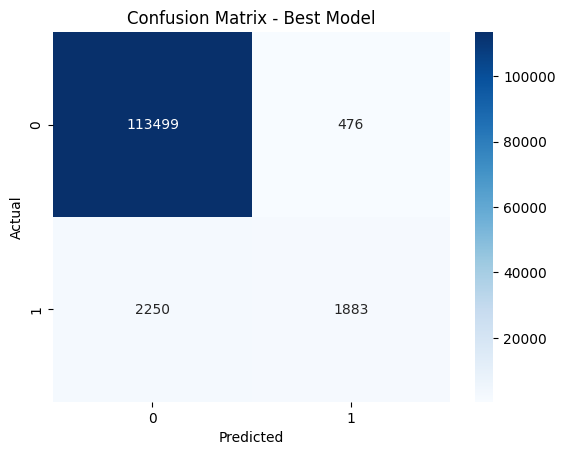

In [58]:
#6: Evaluation of Best Model
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score

# Predict with the best model
y_pred_test = best_model.predict(X_test_scaled)
y_proba_test = best_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_proba_test)

print("\nEvaluation of Best Model:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visual Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Best Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# #6: Online Learning using River

from river import preprocessing as rv_pre
from river import compose as rv_comp
from river import metrics as rv_metrics
from river import linear_model
from tqdm import tqdm

# Sample a manageable portion of data for online simulation
stream_df = df.sample(10000, random_state=42).copy()

# Ensure consistent feature usage
stream_df = stream_df[["isFraud"] + features]

# Initialize the online model pipeline
online_model = rv_comp.Pipeline(
    ('scale', rv_pre.StandardScaler()),
    ('model', linear_model.LogisticRegression())
)

# Initialize metrics
acc = rv_metrics.Accuracy()
rocauc = rv_metrics.ROCAUC()

# Tracking for results
correct = 0
total = 0

# Warm-up phase
WARMUP = 50

# Perform online learning with progress bar
print("Starting River Online Learning...")
for i, row in tqdm(enumerate(stream_df.itertuples(index=False), start=1), total=len(stream_df)):
    row = row._asdict()
    y = row.pop("isFraud")
    x = row

    if i > WARMUP:
        y_pred = online_model.predict_one(x)
        if y_pred is not None:
            acc = acc.update(y, y_pred)
            rocauc = rocauc.update(y, y_pred)
            correct += int(y_pred == y)
        total += 1

    # Learn from the current instance
    online_model = online_model.learn_one(x, y)
    if online_model is None:
        raise RuntimeError("online_model became None after learn_one. Check River version and pipeline usage.")

# Final results
print("\n✅ River Online Learning Summary:")
if total > 0:
    print("Accuracy:", round(acc.get(), 4))
    print("ROC AUC:", round(rocauc.get(), 4))
    print(f"Correct predictions after warm-up: {correct}/{total}")
else:
    print("No valid predictions were made. Try reducing WARMUP or inspecting your data.")


In [ ]:
#7: Save River Model (optional for extended use)
import dill
with open("river_online_model.dill", "wb") as f:
    dill.dump(online_model, f)


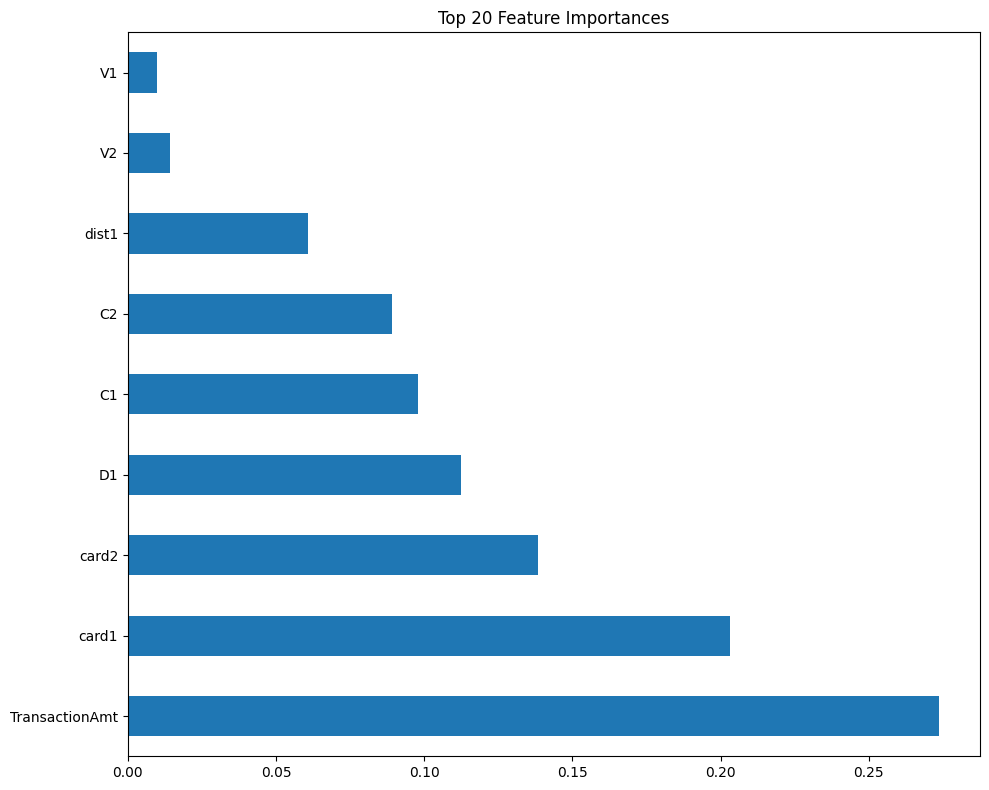

In [47]:
#9: Feature Importance Visualization (for tree models)
if hasattr(best_model, 'feature_importances_'):
    feat_imp = pd.Series(best_model.feature_importances_, index=X.columns)
    feat_imp.nlargest(20).plot(kind='barh', figsize=(10, 8))
    plt.title("Top 20 Feature Importances")
    plt.tight_layout()
    plt.show()


In [ ]:
#10: Final Notes
print("\nWorkflow completed successfully. Model and scaler saved. API ready for deployment.")